# Movie Recommendation System, full project

In [ ]:
import pandas as pd
import numpy as np

# Code to Scrape the data from IMDB user reviews web-links

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import itertools

# movie links corresponding to imdbIDs

base_url = "https://www.imdb.com/title/tt"

movie_links = [base_url + str(identifier) + '/reviews' for identifier in imdbIDs]
movie_links = []
for id in imdbIDs:
  pad0 = "0"*(7 - len(str(id)))
  link = base_url + pad0 + str(id) + "/reviews"
  movie_links.append(link)

def getSoup(url):
  page = requests.get(url)
  if page.status_code == 200:
    return BeautifulSoup(page.content, 'html.parser') 

# Function to scrape Movie name, release year, review dates and Reviews
def getAllFromSoup(soup, verbose = 0):
  #Use the verbose paramater to indicate probability you want the movie name printed. 
    movie_title = ""
    year = ""
    try:
      a_tags = soup.find_all('a', attrs={'class': None})
      movie_title = [tag for tag in a_tags if tag.attrs['href'].startswith('/title') & tag.attrs['href'].endswith('/')][1].getText()
      year = soup.find('span', attrs={'class': 'nobr'}).getText().strip()
    except Exception:
      pass

    ty = movie_title + " " +year
    dates = []
    tag_list = 0

    try:
      tag_list = soup.find_all('span', attrs={"class":"review-date"})
    except Exception:
      pass
    
    try:
      for tag in tag_list:
        dates.append(tag.getText())
    except Exception:
      pass
    reviews = []
    tag_list = 0
    try: 
      tag_list = soup.find_all('div', attrs={'class': 'text show-more__control'})
    except Exception:
      pass

    try :
      for tag in tag_list:
        reviews.append(tag.getText())
    except Exception:
      pass
    
    scrs = []
    revs = soup.find_all('div', attrs={"class":"lister-item-content"})
    # print(len(dates))
    for cnt in range(len(revs)):
      rats = revs[cnt].find_all("span", attrs = {"class":"rating-other-user-rating"})
      if len(rats) == 0:
        scrs.append(np.nan)
        continue
      scr = int(rats[0].text.strip()[:-3])
      scrs.append(scr)
    
    # print(ty)
    if verbose != 0:
      if verbose > random.random():
        # print(movie_title, year)
    return [movie_title, year[1:-1], dates, reviews, scrs]


## Simultaneoulsy Pickling the scraping data to avoid loss

In [ ]:
# 
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

import random
numSplits = 10
dat = movie_links[:100]
l = len(dat)
inds_raw = [int(cnt*l/numSplits) for cnt in range(numSplits+1)]
inds = [(inds_raw[cnt], inds_raw[cnt+1]) for cnt in range(numSplits)]

master = []

for ind in inds:
  print(ind)
  temp = []
  for cnt, url in enumerate(movie_links[ind[0]:ind[1]]):
    if (ind[0] + cnt) % 500 == 0:
      print(ind[0] + cnt)
    temp.append(getAllFromSoup(getSoup(url), 0.01))
  fname = "/content/drive/MyDrive/ReviewData" + str(ind) +".pkl"
  save_object(temp, fname)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mvs = pd.read_csv("movies.csv")
links = pd.read_csv("links.csv")
rats = pd.read_csv("ratings.csv")
tags = pd.read_csv("tags.csv")

# Our dataset

Our dataset consists of 4 files

2 Files are central to our project

## Ratings
This table summarizes rating interactions between users and movies. 

Ratings has just 4 columns
* UserID: A unique id by user
* MovieID: A unique id by movie
* Rating: A rating given between 0.5 and 5. 
* Timestamp: simply the timestamp associated with said interactions


## Tags
Like ratings, this table summarizes user-movie interactions in terms of assigning tags to movies

Tags has just 4 columns
* UserID: A unique id by user
* MovieID: A unique id by movie
* Rtag: A text tag the user associated with the movie
* Timestamp: simply the timestamp associated with said interactions

The other two are less important

## Links
Contains links to other review aggregator websites

## Movies
A simple ID dataset, associating movieID with the title. It has associated genres and release year. 

# Review Analysis - Content Based Filtering

We have scrapd the first page of reviews from every movie in our datatset

## PreProcessing Reviews

In [ ]:
import os
files = []
for file in os.listdir("ReviewData"):
    if file.endswith(".pkl"):
        files.append((os.path.join("ReviewData/", file)))

In [ ]:
import pickle

master = []
for fle in files:
  master.append(pd.read_pickle(fle))

In [ ]:
curr = master[0]

### Let's append all the reviews together

In [ ]:
revs = []
mvs = []
for curr in master:
  for movie in curr:
    mvs.append(movie[0])
    totalRev = " ".join(movie[3])
    revs.append(totalRev)

In [ ]:
words = [len(x.split()) for x in revs]
chars = [len(x) for x in revs]

### Let's see length of concatenated reviews

#### Length in Characters

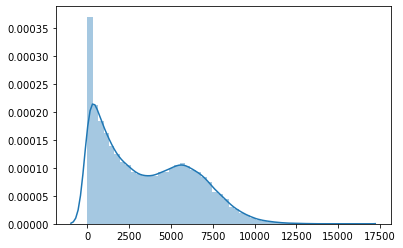

In [ ]:
import seaborn as sns
sns.distplot(words)

#### Length in Words

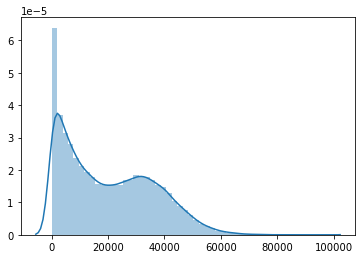

In [ ]:
sns.distplot(chars)

In [ ]:
print("char mean", np.mean(chars))
print("word mean", np.mean(words))

char mean 20102.21489552136
word mean 3517.179816861166


We note similar distributions, with many having no reviews. (around 12%). The means end up being 3517 and 20102 for words anc characters respectively. To avoid cutting off words we will take the first 3000 words for each

In [ ]:
truncatedRevs = [" ".join(x.split()[:3000]) for x in revs]

### Putting it all together

In [ ]:
revData = pd.DataFrame()
revData["movie"] = mvs
revData["reviews"] = truncatedRevs

In [ ]:
revData

,movie,reviews
0,Medea,I first saw Medea in college and was highly cr...
1,Scarlet Diva,"Boy, so much s--t was talked about this film, ..."
2,Bijitâ Q,I've seen over half a dozen Takashi Miike movi...
3,Bolero,"Along three generations, the lives of differen..."
4,Urgh! A Music War,I am now 36 years old and grew up during the d...
...,...,...
58093,Bring It On: Fight to the Finish,Gloria was the hottest but I also had my eyes ...
58094,Scott Joplin,The man who gave us the Maple Leaf Rag and the...
58095,Mater and the Ghostlight,Takes place straight after the movie. In one c...
58096,Your Friend the Rat,This short film was on the Ratatouille DVD as ...


We unfortunately have no choice but to drop movies with no reviews, so as to not mess up the tfidf vectorizer

In [ ]:
revDataFiltered = revData[revData.reviews != ""]

In [ ]:
revDataFiltered

,movie,reviews
0,Medea,I first saw Medea in college and was highly cr...
1,Scarlet Diva,"Boy, so much s--t was talked about this film, ..."
2,Bijitâ Q,I've seen over half a dozen Takashi Miike movi...
3,Bolero,"Along three generations, the lives of differen..."
4,Urgh! A Music War,I am now 36 years old and grew up during the d...
...,...,...
58093,Bring It On: Fight to the Finish,Gloria was the hottest but I also had my eyes ...
58094,Scott Joplin,The man who gave us the Maple Leaf Rag and the...
58095,Mater and the Ghostlight,Takes place straight after the movie. In one c...
58096,Your Friend the Rat,This short film was on the Ratatouille DVD as ...


We only lost around 4000 movies, 7 percent of our dataset. Not bad at all! 

### Getting a TF IDF Represenetation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvect = TfidfVectorizer(lowercase = True, min_df = 5, max_df = 100, stop_words = "english")

In [ ]:
%%time
tfidf = tvect.fit_transform(revDataFiltered["reviews"])

CPU times: user 1min 24s, sys: 2.76 s, total: 1min 26s
Wall time: 1min 31s


#  Content based filtering - Reviews
##### Referring to movie lens data from kaggle:
#### using cosine similarity

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities = linear_kernel(tfidf,tfidf)
movie_title = revDataFiltered['movie']
movie_ID = revDataFiltered['movie']

We have found out cosine similarity for each element of the review

In [ ]:
indices = pd.Series(revDataFiltered.index, index=revDataFiltered['movie'])
indices

movie
Medea                                   0
Scarlet Diva                            1
Bijitâ Q                                2
Bolero                                  3
Urgh! A Music War                       4
                                    ...  
Bring It On: Fight to the Finish    58093
Scott Joplin                        58094
Mater and the Ghostlight            58095
Your Friend the Rat                 58096
Dug's Special Mission               58097
Length: 54965, dtype: int64

Here after creating indices for the revDataFiltered, we use them in the function below to parse through and search for the input title,
Which in our case is 'Scarlet Diva'

In [ ]:
def movie_recommend(original_title):

    idx = indices[original_title]

    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:31]

    movie_indices = [i[0] for i in sim_scores]
    return movie_title.iloc[movie_indices]

movie_recommend('Scarlet Diva')

1778                                Shock
12663    Dario Argento: An Eye for Horror
10106                           Baise-moi
37183       Daria in 'Is It College Yet?'
3505           Daria in 'Is It Fall Yet?'
885                             Phenomena
14920                       Il minestrone
19264       Property Is No Longer a Theft
53469                The Loneliest Planet
25024                     Paganini Horror
693                            Umberto D.
14902                  Angely revolyutsii
28683                                Love
10509                               Opera
1195                             Deep Red
45354                    Le foto di Gioia
34126                     Fantasmi a Roma
38779                      Enter the Void
29264          Be My Cat: A Film for Anne
8283                        I Stand Alone
2903                      Zabriskie Point
307                          Irréversible
13657                 Un'ombra nell'ombra
13676                    Incontro 

The function movie_recommend facilitates in enumerating through the indices of cosine similarity described above to list out movies and their indices 

Trying to save the output recommendations into a dataframe for match checking with genre later

In [ ]:
Grumpier_old_Men_recomm = pd.DataFrame(movie_recommend('Scarlet Diva').head(100))

In [ ]:
Grumpier_old_Men_recomm=Grumpier_old_Men_recomm.reset_index()
Grumpier_old_Men_recomm.columns = ['id', 'original_title']
Grumpier_old_Men_recomm['id']=Grumpier_old_Men_recomm['id'].astype(str)

Here we are using the movielens dataset for the original genre
dropping every aother irrelevant variable

In [ ]:
mv_data = pd.read_csv("movies_metadata.csv")
mv_genre= mv_data.drop(['adult', 'belongs_to_collection', 'budget', 
       'imdb_id', 'original_language' , 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count','homepage'], 1)
mv_genre.drop(mv_genre.loc[mv_genre['id']=='1997-08-20'].index, inplace=True)

/Users/kaustubhlad/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


combining the recommendations with genre on their id's

In [ ]:
combined_test=pd.merge(Grumpier_old_Men_recomm, mv_genre, on='id')

We are here clearing up all the special characters, spaces, user id, numbers, etc just to have the genres

In [ ]:
import re
stop_words = ["id","name"]
pat = '|'.join(r"\b{}\b".format(x) for x in stop_words)
combined_test['genres'] = combined_test['genres'].str.replace(pat, '')
combined_test['genres']=combined_test['genres'].str.replace('\d+', '')
#combined_test['genres'] = combined_test['genres'].map(lambda x: re.sub(r'\W+', '', x))
combined_test['genres'] = combined_test['genres'].map(lambda x: re.sub(r'\W+', '', x))
combined_test['genres'] = combined_test['genres'].str.replace( r"([A-Z])", r" \1").str.strip()

print(combined_test['genres'])

0                    Documentary
1             Action History War
2                          Crime
3                  Drama Romance
4                 Comedy Romance
5     Drama Comedy History Music
6                          Drama
7           Comedy Drama Fantasy
8                  Drama History
9               Family Animation
10           Crime Drama Mystery
Name: genres, dtype: object


now we follow similar approach to get the original genre for the movie of our interst 'Scarlet Diva' from the movielens dataset itself

In [ ]:
genre_test=pd.DataFrame(combined_test['genres'])
genre_test['genres']=pd.DataFrame(combined_test['genres'])
grumpy=mv_genre.loc[mv_genre['original_title'] == 'Scarlet Diva']

In [ ]:
import re
stop_words = ["id","name"]
pat = '|'.join(r"\b{}\b".format(x) for x in stop_words)
grumpy['genres'] = grumpy['genres'].str.replace(pat, '')
grumpy['genres']=grumpy['genres'].str.replace('\d+', '')
grumpy['genres'] = grumpy['genres'].map(lambda x: re.sub(r'\W+', '', x))
grumpy['genres'] = grumpy['genres'].str.replace( r"([A-Z])", r" \1").str.strip()


print(grumpy['genres'])

5770    Drama
Name: genres, dtype: object


<ipython-input-43-0868bbf58c06>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grumpy['genres'] = grumpy['genres'].str.replace(pat, '')
<ipython-input-43-0868bbf58c06>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grumpy['genres']=grumpy['genres'].str.replace('\d+', '')
<ipython-input-43-0868bbf58c06>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

We replicate the 'Scarlet Diva' movie title, genre and ID to the number of recommendations

In [ ]:
grumpy_pred_genre=pd.concat([grumpy['genres']]*11, ignore_index=True)

checking if 'Scarlet Diva' movie's genre tags are in the genre defined for the recommended movies using 'in'

In [ ]:
genre_test["Y"] = genre_test['genres'].map(lambda x: "1" if "Drama" in x else "1" if "drama" in x else "0")
genre_test["Y"] = genre_test['genres'].map(lambda x: "1" if "Drama" in x else "1" if "drama" in x else "0")


grumpy_pred_genre["Y"] = grumpy_pred_genre.map(lambda x: "1" if "Drama" in x else "1" if "drama" in x else "0")





Evaluating out approach with accuracy and MAPE

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(genre_test["Y"], grumpy_pred_genre["Y"])

0.5454545454545454

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(genre_test["Y"], grumpy_pred_genre["Y"])
print(f'Test MAE: {mae:.2f}')

Test MAE: 0.45


# # Content based filtering - Overviews
##### Using movie lens data from kaggle:

We follow similar approach to that of Reviews except here the overviews are also from the movielens dataset.

In [ ]:
mv_data_a = mv_data.drop(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 
       'imdb_id', 'original_language','popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'], 1)

In [ ]:
mv_data_b=mv_data_a.dropna()
mv_data_b.isnull().sum()

id                0
original_title    0
overview          0
dtype: int64

 tf_idf matrix since all we have is words in overviews

In [ ]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
tvect = TfidfVectorizer(lowercase = True, min_df = 5, max_df = 100, stop_words = "english")

In [ ]:
tfidf = tvect.fit_transform(mv_data_b["overview"])

Using cosine similarity from sklearn's linear_kernal and producing indices and ID like before

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities = linear_kernel(tfidf,tfidf)
movie_title = mv_data_b['original_title']
movie_ID = mv_data_b['id']
indices = pd.Series(mv_data_b.index, index=mv_data_b['original_title'])

In [ ]:
def movie_recommend(original_title):

    idx = indices[original_title]

    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:51]

    movie_indices = [i[0] for i in sim_scores]
    return movie_title.iloc[movie_indices]

We now take the recommendations for the movie 'Grumpy Old Men' and do the necessary like last time

In [ ]:
Grumpier_old_Men_recomm = pd.DataFrame(movie_recommend('Grumpier Old Men').head(100))

In [ ]:
Grumpier_old_Men_recomm=Grumpier_old_Men_recomm.reset_index()
Grumpier_old_Men_recomm.columns = ['id', 'original_title']

combining the recommendations for the movie of interest and their original genre from movielens dataset

In [ ]:
Grumpier_old_Men_recomm['id']=Grumpier_old_Men_recomm['id'].astype(str)


combined_test=pd.merge(Grumpier_old_Men_recomm, mv_genre, on='id')

Eliminating special characters etc

In [ ]:
import re
stop_words = ["id","name"]
pat = '|'.join(r"\b{}\b".format(x) for x in stop_words)
combined_test['genres'] = combined_test['genres'].str.replace(pat, '')
combined_test['genres']=combined_test['genres'].str.replace('\d+', '')
#combined_test['genres'] = combined_test['genres'].map(lambda x: re.sub(r'\W+', '', x))
combined_test['genres'] = combined_test['genres'].map(lambda x: re.sub(r'\W+', '', x))
combined_test['genres'] = combined_test['genres'].str.replace( r"([A-Z])", r" \1").str.strip()

print(combined_test['genres'])

0                                       Drama
1                                 Drama Music
2                                       Drama
3              Comedy Horror Mystery Thriller
4                                 Crime Drama
5                                   Drama War
6                               Comedy Family
7                                      Comedy
8     Adventure Drama Action Thriller Romance
9                        Drama Fantasy Horror
10                                     Horror
11                        War Action Thriller
12                      Romance Drama History
13                     Action Comedy Thriller
14                                     Horror
15                                      Drama
16                          Documentary Music
17                    Comedy Mystery Thriller
18                         Action Crime Drama
19                 Adventure Animation Comedy
20                     Horror Science Fiction
21                     Adventure D

Getting the genre for the movie of interest from the movie lens dataset

In [ ]:
genre_test=pd.DataFrame(combined_test['genres'])
genre_test['genres']=pd.DataFrame(combined_test['genres'])
grumpy=mv_genre.loc[mv_genre['original_title'] == 'Grumpier Old Men']




In [ ]:
import re
stop_words = ["id","name"]
pat = '|'.join(r"\b{}\b".format(x) for x in stop_words)
grumpy['genres'] = grumpy['genres'].str.replace(pat, '')
grumpy['genres']=grumpy['genres'].str.replace('\d+', '')
grumpy['genres'] = grumpy['genres'].map(lambda x: re.sub(r'\W+', '', x))
grumpy['genres'] = grumpy['genres'].str.replace( r"([A-Z])", r" \1").str.strip()


print(grumpy['genres'])

2    Romance Comedy
Name: genres, dtype: object


<ipython-input-62-0868bbf58c06>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grumpy['genres'] = grumpy['genres'].str.replace(pat, '')
<ipython-input-62-0868bbf58c06>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grumpy['genres']=grumpy['genres'].str.replace('\d+', '')
<ipython-input-62-0868bbf58c06>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

Creating a yes or no array for all the recommendations from the approach to check if they match with the genre of the movie of our interest

In [ ]:
grumpy_pred_genre=pd.concat([grumpy['genres']]*28, ignore_index=True)
genre_test["Y"] = genre_test['genres'].map(lambda x: "1" if "Romance" in x else "1" if "Comedy" in x else "0")
genre_test["Y"] = genre_test['genres'].map(lambda x: "1" if "Romance" in x else "1" if "Comedy" in x else "0")


grumpy_pred_genre["Y"] = grumpy_pred_genre.map(lambda x: "1" if "Romance" in x else "1" if "Comedy" in x else "0")





The accuracy and MAPE for the approach of using cosine similarity on overviews to suggest movies are

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(genre_test["Y"], grumpy_pred_genre["Y"])

0.35714285714285715

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(genre_test["Y"], grumpy_pred_genre["Y"])
print(f'Test MAE: {mae:.2f}')

Test MAE: 0.64


# Tag Analysis: Content Based Filtering

In [ ]:
tags

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195
...,...,...,...,...
1108992,283206,73017,fun,1264379059
1108993,283206,73017,homoerotic subtext,1264379058
1108994,283206,73017,pacing,1264379058
1108995,283206,73017,plot,1264379058


## Here, let's only consider tags that appear more than 5 times. 

In [ ]:
unique_tags = set(tags["tag"])

In [ ]:
len(unique_tags)

74715

### We have just under 75000 unique tags

In [ ]:
tags["tag"].value_counts()

sci-fi                     9400
atmospheric                6430
action                     6219
comedy                     5923
surreal                    5299
                           ... 
Ward Bond                     1
ever heard of columbine       1
thai boxen                    1
logic vs superstition         1
evening gown                  1
Name: tag, Length: 74714, dtype: int64

In [ ]:
g5locsTags = np.argwhere(tags.groupby("tag").count()["userId"].values > 5).flatten()

In [ ]:
g5movsTags = tags["tag"].value_counts().sort_index().index[g5locsTags]

In [ ]:
tags["tag"].value_counts()[g5movsTags]

"damn dirty apes"     16
"found footage"       90
"not so perfect"       8
(s)vcd                33
*Good* Musicals       12
                      ..
zoo                   44
zooey deschanel        6
zurich                 7
                      10
Álex de la Iglesia    10
Name: tag, Length: 15894, dtype: int64

## "Only" around 16000 are used more than 5 times

In [ ]:
import seaborn as sns
pd.DataFrame(tags["tag"].value_counts()[g5movsTags].values).describe()

,0
count,15894.000000
mean,63.442117
std,253.428275
min,6.000000
25%,8.000000
50%,14.000000
75%,35.000000
max,9400.000000


Now we build a dataframe with movie, tag, the number of people who gave that movie that tag

In [ ]:
master = []
for cnt, mid in enumerate(list(set(tags["movieId"]))):
  if cnt % 10000 == 0:
    print(cnt)
  curr = tags[tags.movieId == mid]
  cnts = curr["tag"].value_counts()
  for item, val in cnts.items():
    if item in g5movsTags:
      continue
    master.append([mid, item, val])

0
10000
20000
30000
40000


In [ ]:
mov_tag = pd.DataFrame(master, columns = ["movieId", "tag", "n_tagged"])

Now we will build what is essentially a term frequency matrix

In [ ]:
mov_tag

,movieId,tag,n_tagged
0,1,ya boy,1
1,1,soothing,1
2,1,fast and a furious,1
3,1,Toy Story,1
4,1,Woody,1
...,...,...,...
85176,131050,symbiote,1
85177,131060,egomania,1
85178,131066,barbarians,2
85179,131066,common fantasy themes,1


We need to get this in matrix format where i,j tells us the number of times movie i was tagged with tag j. We will put this information in a sparse matrix to save space.

In [ ]:
cols = []
rows = []
vals = []
ms = {}
ts = {}
mcnt = 0
tcnt = 0
for cnt,x in enumerate(mov_tag.iterrows()):
  row = x[1]
  tag = row["tag"]
  count = row["n_tagged"]
  mv = row["movieId"]
  if tag not in ts.keys():
    ts[tag] = tcnt
    tcnt += 1
  cols.append(ts[tag])
  if mv not in ms.keys():
    ms[mv] = mcnt
    mcnt += 1
  rows.append(ms[mv])
  vals.append(count)
  if cnt%10000 == 0:
    print(cnt)

0
10000
20000
30000
40000
50000
60000
70000
80000


In [ ]:
import scipy.sparse as sp
m1 = sp.coo_matrix((vals, (rows, cols)))

# Treat as bag of words and make tf_idf matrix

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer as tit

t1 = tit()

m2 = t1.fit_transform(m1)

In [ ]:
%%time
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities = linear_kernel(m2,m2)

CPU times: user 124 ms, sys: 400 ms, total: 524 ms
Wall time: 578 ms


In [ ]:
cosine_similarities.shape

(25031, 25031)

Only 25000 movies have tags that meet out threshold. So a huge limitation is, that we can only predict on these movies. 

Now we make a reccomendation function that reccomends the top X similar movies by the tag tf_idf matrix. We don't reccomend movies that have 0 similarity. 

In [ ]:

#
def movie_recommend(idx, thresh = 10):
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    rel_sim_scores = []
    for val in sim_scores:
      if val[0] == idx:
        continue
      if val[1] == 0:
        break
      if len(rel_sim_scores) > thresh:
        break
      rel_sim_scores.append(val)
    sim_scores = rel_sim_scores
    movie_indices = [i[0] for i in sim_scores]
    return movie_indices

In [ ]:
movie_recommend(2902)

[4553, 3453, 13856, 13781, 12373, 7412, 211, 3664]

To evaluate, we need concrete movie names, not just numbers. We make a reverse mapping that maps tag index to movie id, we will use this later

In [ ]:
rev_mvs = {v:k for k,v in ms.items()}
rev_ts = {v:k for k,v in ts.items()}

In [ ]:
def getMovieTitle(idx):
  return mvs[mvs.movieId == rev_mvs[idx]]

## Filtering By Genres

# New Section

### We have 58000 movies. We can see the title also has the release year. 

### Let's split up the release year with the title. 

We will use some regular expressions to split it. 

In [ ]:
mvs = pd.read_csv("movies.csv")
mv_year = mvs["title"].str.strip().str.extract(r"(.*)\s?\((\d{4})\)$")
mv_year.columns = (["title2", "ryear"])
mv_year

,title2,ryear
0,Toy Story,1995
1,Jumanji,1995
2,Grumpier Old Men,1995
3,Waiting to Exhale,1995
4,Father of the Bride Part II,1995
...,...,...
58093,The Great Glinka,1946
58094,Les tribulations d'une caissière,2011
58095,Her Name Was Mumu,2016
58096,Flora,2017


### Let's merge this with our dataset 

We do not drop the title column yet. We will need it in case there are issues with our regex

In [ ]:
mvs2 = mvs.join(mv_year)
mvs2

,movieId,title,genres,title2,ryear
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995
...,...,...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed),The Great Glinka,1946
58094,193878,Les tribulations d'une caissière (2011),Comedy,Les tribulations d'une caissière,2011
58095,193880,Her Name Was Mumu (2016),Drama,Her Name Was Mumu,2016
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi,Flora,2017


### Where did this fail?

In [ ]:
mvs2[mvs2["ryear"].isna()]

,movieId,title,genres,title2,ryear
10023,32930,Category 6: Day of Destruction,Action|Drama,NaN,NaN
10613,40697,Babylon 5,Sci-Fi,NaN,NaN
15719,79607,"Millions Game, The (Das Millionenspiel)",Action|Drama|Sci-Fi|Thriller,NaN,NaN
17444,87442,"Bicycle, Spoon, Apple (Bicicleta, cullera, poma)",Documentary,NaN,NaN
20012,98063,Mona and the Time of Burning Love (Mona ja pal...,Drama,NaN,NaN
...,...,...,...,...,...
57504,192339,The Sign of Three,(no genres listed),NaN,NaN
57674,192829,Parwaaz Hai Junoon,Adventure|Children|Romance,NaN,NaN
57789,193149,¿Qué te juegas?,(no genres listed),NaN,NaN
57903,193443,Wall,(no genres listed),NaN,NaN


### We have some missing data. Let's move the title to our "title2" column and keep ryear NaN for this

In [ ]:
mvs2["title2"] = mvs2["title2"].fillna(mvs2["title"])
mvs = mvs2
#convering to numerical
mvs["ryear"] = mvs["ryear"].astype("float")

## Exploring the Movies table

### Let's see the year distribution

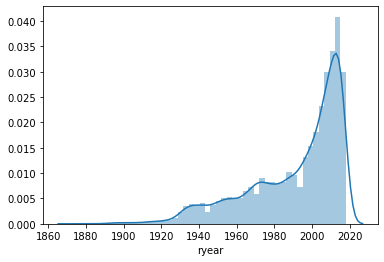

In [ ]:
%matplotlib inline

import seaborn as sns

sns.distplot(mvs["ryear"].dropna())

#### We clearly see that newer movies are much more common than earlier ones.

### Let's see the genres

These are harder to tackle since they are split by "|" and there can be many of them.

First let's see how many genre each movie has. After that we will see the most popular genres

In [ ]:
#convert genre column to python list
genLists = mvs["genres"].str.split("|")

#get lengths of aforementioned lists
#if there is "no genre listed" we set length to 0
genLen = genLists.apply(lambda x: len(x) if x[0].strip() != "(no genres listed)" else 0)

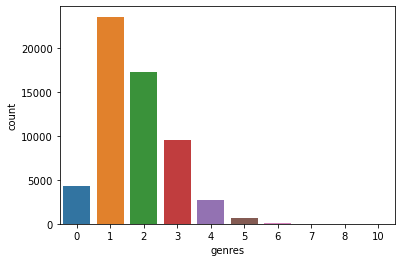

In [ ]:
sns.countplot(genLen.dropna())

### 1,2,3 genres are most common

## Let's see the most common genres

In [ ]:
genre_count = {}

for l in genLists:
    for x in l:
        if x not in genre_count:
            genre_count[x] = 1
        else:
            genre_count[x] += 1

In [ ]:
genre_count

{'Adventure': 4067,
 'Animation': 2663,
 'Children': 2749,
 'Comedy': 15956,
 'Fantasy': 2637,
 'Romance': 7412,
 'Drama': 24144,
 'Action': 7130,
 'Crime': 5105,
 'Thriller': 8216,
 'Horror': 5555,
 'Mystery': 2773,
 'Sci-Fi': 3444,
 'IMAX': 197,
 'Documentary': 5118,
 'War': 1820,
 'Musical': 1113,
 'Western': 1378,
 'Film-Noir': 364,
 '(no genres listed)': 4266}

### Let's graph it

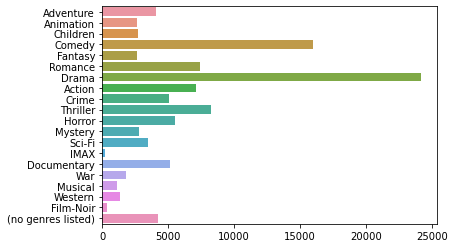

In [ ]:
#turn into series for easy graphing
gc = pd.Series(genre_count)

sns.barplot(gc.values, gc.index)
from matplotlib import rcParams

rcParams['figure.figsize'] = 20,10

### Drama and Comedy seem to be the most popular ones. Quite a few have no genre as well

Next, let's see correlation between the genres. How often is one genre with another. This one we do need to do a bit of work for. One-hot encoding the genres. 

In [ ]:
mvs["genList"] = genLists

In [ ]:
#Source: https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list
# We use this to easily one-hot encode from list columns

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mvs3 = mvs.join(pd.DataFrame(mlb.fit_transform(mvs.pop('genList')),
                          columns=mlb.classes_,
                          index=mvs.index))

In [ ]:
master = mvs3

# A very naive model 
This way our recommendation system will recommend movies similar to a movie provided.  

In [ ]:
# in the spirit of naivete, we will use K-means
#More advanced future models of course will leverage tags

from sklearn.cluster import KMeans 
from sklearn.preprocessing import MinMaxScaler

### For our dataset, we only consider the numerical columns (including the one-hot vectors)

In [ ]:
cols = ["ryear"] + list(gc.index)
X = master[cols]

## Drop NANs

In [ ]:
X = X.dropna()

### Normalize

In [ ]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [ ]:
dists = []

cluster_cands = list(range(2,30))
for k in cluster_cands:
    print(k)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_norm)
    dists.append(kmeans.inertia_)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


Text(0.5, 0, '# of Clusters')

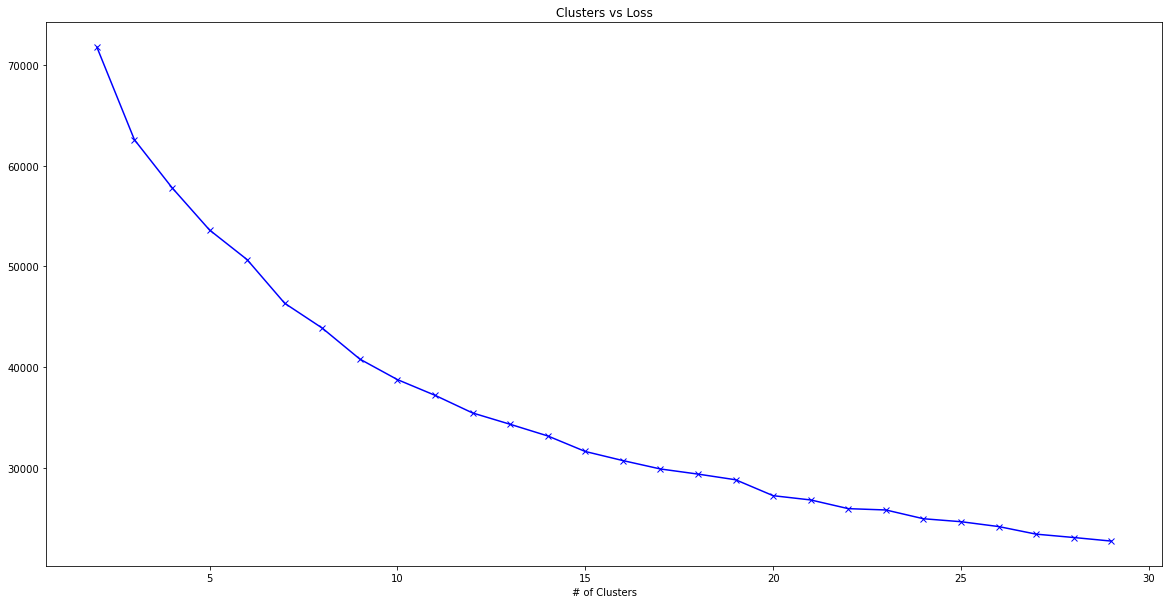

In [ ]:
#Loss and number of clusters
import matplotlib.pyplot as plt

plt.plot(cluster_cands,dists, 'xb-')
plt.title("Clusters vs Loss")
plt.xlabel("# of Clusters")

No elbow appears. Trying with higher clusters shows intertia still decreasing dramatically. Let's settle on very large numbebr of clusters

In [ ]:
kmeans = KMeans(n_clusters=500)
kmeans.fit(X_norm)
dists.append(kmeans.inertia_)

In [ ]:
labs = kmeans.labels_

In [ ]:
naive_master = master.dropna()
naive_master["groupings"]= labs

### Let's test to see similarities

In [ ]:
sel = 17

naive_master[naive_master["groupings"] == sel]["title"][:10]

60           Eye for an Eye (1996)
78               Juror, The (1996)
98                City Hall (1996)
215         Babysitter, The (1995)
222              Disclosure (1994)
226    Death and the Maiden (1994)
227       Dolores Claiborne (1995)
277     Murder in the First (1995)
288           Poison Ivy II (1996)
432          Color of Night (1994)
Name: title, dtype: object

Comparing all against each other

In [ ]:
idx = 13
tit = getMovieTitle(idx)["title"].values[0]
close = movie_recommend(idx)
print(tit, "Tag Analysis Reccomends: ")
for x in close:
  print(getMovieTitle(x)["title"].values[0])
cls = naive_master[naive_master["title"] == tit].groupings.values[0]
print("****")
print("Genre Analysis has", tit, "in cluster", cls)
for x in close:
  ctit = getMovieTitle(x)["title"].values[0]
  print(ctit, "is in cluster", naive_master[naive_master["title"] == ctit].groupings.values[0])

Casino (1995) Tag Analysis Reccomends: 
Kundun (1997)
What Happens in Vegas... (2008)
Us and Them (2017)
District, The (Nyócker!) (2004)
Festival At The Poolroom (1975)
Taxi Driver (1976)
Hail, Caesar! (2016)
Dances with Wolves (1990)
Goodfellas (1990)
Hangover, The (2009)
****
Genre Analysis has Casino (1995) in cluster 330
Kundun (1997) is in cluster 173
What Happens in Vegas... (2008) is in cluster 0
Us and Them (2017) is in cluster 25
District, The (Nyócker!) (2004) is in cluster 61
Festival At The Poolroom (1975) is in cluster 401
Taxi Driver (1976) is in cluster 25
Hail, Caesar! (2016) is in cluster 224
Dances with Wolves (1990) is in cluster 183
Goodfellas (1990) is in cluster 330
Hangover, The (2009) is in cluster 57


Clearly both of these disagree

We need some way to evaluate

## Evaluating Content-based Recs

In [ ]:
def trueSimilarity(aid, bid, thresh = 2):
  fltr = rats[(rats.movieId == aid) | (rats.movieId == bid)]
  cnts = fltr.groupby("userId").count()
  sboth = cnts[cnts.rating == 2].index
  arats = fltr[fltr.userId.isin(sboth)][fltr.movieId == aid]
  brats = fltr[fltr.userId.isin(sboth)][fltr.movieId == bid]
  mrgd = arats.merge(brats[["rating", "userId"]], on = "userId")
  if mrgd.shape[0] <= thresh:
    return np.nan
  return mrgd["rating_x"].corr(mrgd["rating_y"])

First we should see what the average similarity is to check out the distribution. 

We use bootstrap to develop a distribution (sampling with replacement), and rely on the CLT to give us a good idea

We do not count those with less than 5 users

Distribution of Absolute Similarity

In [ ]:
sims = []
mids = mvs["movieId"].values
import random
for cnt in range(10000):
  if cnt % 100 == 0:
    print(cnt)
  samp = random.choices(mids, k =2)
  sims.append(trueSimilarity(samp[0], samp[1]))

Text(0.5, 1.0, 'True Similarity')

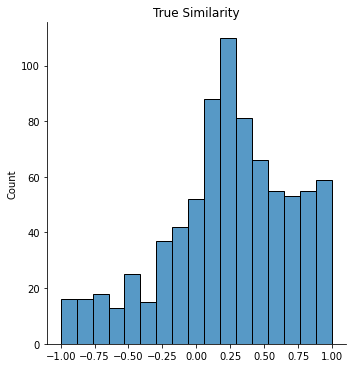

In [ ]:
import matplotlib.pyplot as plt

ax = sns.displot([x for x in sims])
plt.title("True Similarity")

In [ ]:
pd.DataFrame([x for x in sims]).describe()

,0
count,801.000000
mean,0.233519
std,0.470150
min,-1.000000
25%,0.000000
50%,0.254279
75%,0.557282
max,1.000000


Example of evaluating tag similarity against true similarity

In [ ]:
%%time
import warnings
warnings.filterwarnings('ignore')
idx = 10922
tit = getMovieTitle(idx)["title"].values[0]
close = movie_recommend(idx)
print(tit, "Tag Analysis Reccomends: ")
for x in close:
  print(getMovieTitle(x)["title"].values[0], "with true similarity", trueSimilarity(rev_mvs[x], rev_mvs[idx]))
print("****")

Kingdom of Heaven (2005) Tag Analysis Reccomends: 
King Richard And The Crusaders (1954) with true similarity nan
Jane Eyre (2011) with true similarity 0.20799682754609433
Hell Ride (2008) with true similarity 0.40384914015570333
Love Letter (1995)  with true similarity nan
Thirteen, The (Trinadtsat) (1937) with true similarity nan
George and the Dragon (2004) with true similarity nan
Robin Hood: Prince of Thieves (1991) with true similarity 0.33436874065860983
Grey, The (2012) with true similarity 0.33778333749465805
Shutter Island (2010) with true similarity 0.2762951777902482
300 (2007) with true similarity 0.3210231016030079
****
CPU times: user 1.52 s, sys: 25.9 ms, total: 1.54 s
Wall time: 794 ms


Final Evaluation

In [ ]:
simsT = []
simsG = []
mids = mvs["movieId"].values
import random
for cnt in range(1000):
  idx = random.choices(list(range(cosine_similarities.shape[0])), k =1)[0]
  if cnt % 100 == 0:
    print(cnt)
  warnings.filterwarnings('ignore')
  tit = getMovieTitle(idx)["title"].values[0]
  close = movie_recommend(idx)
  #print(tit, "Tag Analysis Reccomends: ")
  for x in close:
    #print(getMovieTitle(x)["title"].values[0], "with true similarity", trueSimilarity(rev_mvs[x], rev_mvs[idx]))
    simsT.append(trueSimilarity(rev_mvs[x], rev_mvs[idx]))
  #print("****")
  #print("Genre Analysis Reccomends")
  f = naive_master[naive_master["title"] == tit]
  if f.shape[0] == 0:
    continue
  cls = f.groupings.values[0]
  fltrd = naive_master[naive_master.groupings == cls][:10]["movieId"].values
  for x in fltrd:
    #print(getMovieTitle(x)["title"].values[0], "with true similarity", trueSimilarity(x, rev_mvs[idx]))
    simsG.append(trueSimilarity(x, rev_mvs[idx]))

0
100
200
300
400
500
600
700
800
900


Tags Similarity Evaluation

Text(0.5, 1.0, 'True Similarity - Tag Reccomendations')

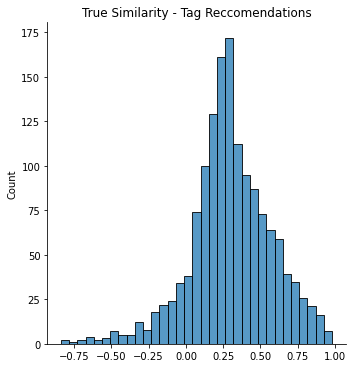

In [ ]:
import matplotlib.pyplot as plt

ax = sns.displot([x for x in simsT])
plt.title("True Similarity - Tag Reccomendations")

In [ ]:
pd.DataFrame([x for x in simsT]).describe()

,0
count,1457.000000
mean,0.298902
std,0.273092
min,-0.839475
25%,0.155208
50%,0.287392
75%,0.468097
max,0.980940


Genre Evaluation

Text(0.5, 1.0, 'True Similarity - Genre Clusters')

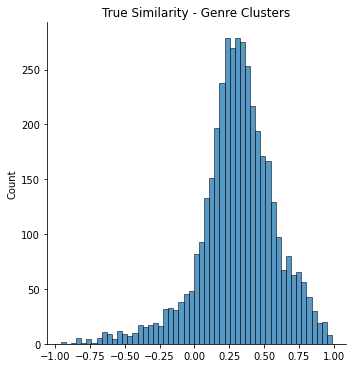

In [ ]:
import matplotlib.pyplot as plt

ax = sns.displot([x for x in simsG])
plt.title("True Similarity - Genre Clusters")

In [ ]:
pd.DataFrame([x for x in simsG]).describe()

,0
count,4068.000000
mean,0.308623
std,0.274178
min,-0.960347
25%,0.174567
50%,0.316062
75%,0.472868
max,0.988787


# Interaction Analysis - Collabirative Filtering

We have multiple ways to go about this. Here we have a clear labeled dataset that we can conduct supervised learning on, but it is fairly difficult to do so in the current state. 

In [ ]:
rats

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


## The Non-Deep Solution: SVD

SVD is the state of the art way to do collaborative filtering. Since we have sparse matrices, we use a variant that leverages sparse nature to simplify MSE calculations

### Splitting our data into training, validation, and testing.

We split by users. We don't want the same user to be in both sets. 

In [ ]:
master = rats.drop(columns = "timestamp")
from sklearn.model_selection import train_test_split
import numpy as np

train, test = train_test_split(list(set(master["userId"])), test_size=0.2, random_state=42, shuffle = True)
train,val = train_test_split(train, test_size=0.2, random_state=42, shuffle = True)

In [ ]:
#!pip install git+https://github.com/gbolmier/funk-svd
from funk_svd import SVD
svd = SVD(learning_rate=0.001, regularization=0.005, n_epochs=100, n_factors=15, min_rating=0.5, max_rating=5)

In [ ]:
master.columns = ["u_id", "i_id", "rating"]

In [ ]:
%%time
tr = master.loc[master.u_id.isin(train)]
print("Train Allocated")
vl = master.loc[master.u_id.isin(val)]
print("Val Allocated")
tt = master.loc[master.u_id.isin(test)]
print("Test Allocated")

Train Allocated
Val Allocated
Test Allocated
CPU times: user 6.14 s, sys: 36.9 ms, total: 6.17 s
Wall time: 6.18 s


In [ ]:
svd.fit(X=tr, X_val=vl, early_stopping=True, shuffle=False)

Preprocessing data...

Epoch 1/100  | val_loss: 0.95 - val_rmse: 0.98 - val_mae: 0.75 - took 1.2 sec
Epoch 2/100  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.75 - took 1.3 sec
Epoch 3/100  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.75 - took 1.2 sec
Epoch 4/100  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.74 - took 1.2 sec

Training took 10 sec


In [ ]:
pred = svd.predict(tt)

In [ ]:
np.std(pred)

0.4211983108844682

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
mae = mean_absolute_error(tt['rating'], pred)
mse = mean_squared_error(tt['rating'], pred)
print(f'Test MAE: {mae:.2f}')
print(f'Test MSE: {mse:.2f}')

Test MAE: 0.75
Test MSE: 0.94


This is an excellent result! We are on average, off by 0.75 when predicting a rating. When considering that actual ratings only occur at intervals of 0.5 anyways, this is a great result. 

We can probabaly tune our paramaters more using cross validation (though this will be slow). See some examples below, with different parameters:

In [ ]:
svd = SVD(learning_rate=0.001, regularization=0.005, n_epochs=100, n_factors=55, min_rating=0.5, max_rating=5)
svd.fit(X=tr, X_val=vl, early_stopping=True, shuffle=False)
pred = svd.predict(tt)
mae = mean_absolute_error(tt['rating'], pred)
mse = mean_squared_error(tt['rating'], pred)
print(f'Test MAE: {mae:.2f}')
print(f'Test MSE: {mse:.2f}')

Preprocessing data...

Epoch 1/100  | val_loss: 0.95 - val_rmse: 0.98 - val_mae: 0.75 - took 3.7 sec
Epoch 2/100  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.75 - took 3.6 sec
Epoch 3/100  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.75 - took 3.4 sec
Epoch 4/100  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.74 - took 3.2 sec

Training took 19 sec
Test MAE: 0.75
Test MSE: 0.94


In [ ]:
svd = SVD(learning_rate=0.001, regularization=0.05, n_epochs=100, n_factors=15, min_rating=0.5, max_rating=5)
svd.fit(X=tr, X_val=vl, early_stopping=True, shuffle=False)
pred = svd.predict(tt)
mae = mean_absolute_error(tt['rating'], pred)
mse = mean_squared_error(tt['rating'], pred)
print(f'Test MAE: {mae:.2f}')
print(f'Test MSE: {mse:.2f}')

Preprocessing data...

Epoch 1/100  | val_loss: 0.95 - val_rmse: 0.98 - val_mae: 0.75 - took 1.3 sec
Epoch 2/100  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.75 - took 1.3 sec
Epoch 3/100  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.75 - took 1.3 sec
Epoch 4/100  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.75 - took 1.3 sec

Training took 10 sec
Test MAE: 0.75
Test MSE: 0.94


Not much difference is made

# COLLABORATIVE FILTERING II

First question is what is collaborative filtering ? Simple answer is that it is user based recommendation system. Which means that I will recommend you one item that other users that are similar to you liked. This recommendation used by many big companies likes of Google, Netflix, Amazon etc. If you see in those companies website they show us that you may like this product or movies because some of the users similar to you also like this. So, what it means by similar users like you and how they find that ? So, let's take an example of Netflix, you liked couple of movies like 
'Batman' , 'Inception' .Now as per the database there is one user who also likes this movies and he like movie 'Prestige' but you haven't watch this movie then it will recommend you to watch that movie. They will find the similarity between two user using the rating given by users in the previously watched movie and to calculate some kind of number to compare they use Euclidean distance, Pearson Correlation, Cosine distance etc. There is no fix one computaion method. Those companies also use some personal information like user's age, profession, hobbies etc not just the rating but those companies have those kind of information.

# Reading the dataset

We need two tables for this

1. Movies: to get movie title
2. Ratings: to get user ratings

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
mvs = pd.read_csv(r"C:/Users/Drashti Patel/Desktop/BIA 660/movies.csv")
rats = pd.read_csv(r"C:/Users/Drashti Patel/Desktop/BIA 660/ratings.csv")

In [ ]:
mvs

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


In [ ]:
rats

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


Remove unnecessary fields and merge both dataframe into one

In [ ]:
mvs = mvs[['movieId','title']]
rats = rats[['userId','movieId','rating']]
data = pd.merge(rats,mvs)
data.head()

,userId,movieId,rating,title
0,1,307,3.5,Three Colors: Blue (Trois couleurs: Bleu) (1993)
1,6,307,4.0,Three Colors: Blue (Trois couleurs: Bleu) (1993)
2,56,307,4.0,Three Colors: Blue (Trois couleurs: Bleu) (1993)
3,71,307,5.0,Three Colors: Blue (Trois couleurs: Bleu) (1993)
4,84,307,3.0,Three Colors: Blue (Trois couleurs: Bleu) (1993)


Check for column with missing value in drop thoe data

In [ ]:
data.isnull().sum()

userId     0
movieId    0
rating     0
title      0
dtype: int64

In [ ]:
data.shape

(27753444, 4)

Dataset is very big and it can take lot of computaion. So, taking data of first 100 users and then split out dataset into two parts for testing and training. We will use 80% of our data for training our model. We split it randomly but try to train using all users rating.

In [ ]:
def split_data_groupwise(df):
    ids = np.random.choice(df.index,size=np.int64(np.ceil(df.index.size * 0.2)),replace=False)
    df.loc[ids, 'test'] = True
    return df

In [ ]:
data['test'] = False
data = data[data['userId']<100]
group = data.groupby('userId', group_keys=False).apply(split_data_groupwise)
data_train = data[group.test == False]
data_test = data[group.test == True]

In [ ]:
remove = list(data.userId.value_counts().loc[lambda x: x==1].reset_index()['index'])
data_train = data_train[~data_train['userId'].isin(remove)]
data_test = data_test[~data_test['userId'].isin(remove)]

We are going to use Pearson correlation to calculate similarity between two users as we already use cosine similarity

# Train our Model

In [ ]:
from scipy.stats import pearsonr
def Pearson(df,u1,u2):
    #movies rated by user1 and user2
    df_u1=df[df['userId']==u1]
    df_u2=df[df['userId']==u2]
    # similar movies rated by both the users
    both_u = pd.merge(df_u1,df_u2,on='movieId')
    # if both user rated less than 2 similar movies then return 0 without computing
    if len(both_u)<2:
        return 0
    result = pearsonr(both_u.rating_x,both_u.rating_y)[0]
    if(np.isnan(result)):
        return 0
    return result

In [ ]:
#All user list 
all_users = set(data_train.userId)
similarity_result = {}
for i in all_users:
    similarity_result.setdefault(i,{})
    #take all the movies watched by user i
    movies_i = data_train[data_train['userId']==i]['movieId']
    temp=pd.merge(data_train,movies_i,on='movieId')
    for j in all_users:
        if i==j:
            continue
        similarity_result.setdefault(j,{})    
        s = Pearson(temp,i,j)
        if (s<0):
            similarity_result[i][j] = 0
            similarity_result[j][i] = 0
        else:
            similarity_result[i][j] = s
            similarity_result[j][i] = s

C:\Users\Drashti Patel\anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [ ]:
similarity_result[15]

{1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0.5646892550534337,
 6: 0,
 7: 0,
 8: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0.059907344360913974,
 16: 0,
 17: 0,
 18: 0.8017837257372731,
 19: 0.3859224924939798,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0,
 30: 0,
 31: 0,
 32: 0.8703882797784892,
 34: 0,
 35: 0,
 36: 0.028676966733820215,
 37: 0,
 38: 0.128920512778062,
 39: 0.0,
 40: 0,
 41: 0,
 42: 0.3192758757255233,
 43: 0.14907119849998596,
 44: 0,
 45: 0.6454972243679027,
 46: 0,
 47: 0,
 48: 0.2612254092291134,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0.8664002254439633,
 60: 0.6363636363636362,
 61: 0,
 62: 0.9999999999999998,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0.8064193829708235,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0.3238507828630997,
 74: 0,
 75: 0.32268124160757616,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0.1528302518545856,
 82: 0,
 83: 0,
 84: 0.4795517914678532,
 85: 0,
 86: 0,
 87: 0,


In [ ]:
def predict(user,movie): 
        allratings=data_train[(data_train['movieId']==movie)]
        allusers_movie=set(allratings.userId)
        
        numerator=0.0
        denominator=0.0
        
        for u in allusers_movie:
            if u==user:continue
            #we calculate the numerator and denominator of the prediction formula we saw at the beginning
            numerator+=similarity_result[user][u]*float(allratings[allratings['userId']==u]['rating'])
            denominator+=similarity_result[user][u]
                
        if denominator==0: 
            if data_train.rating[data_train['movieId']==movie].mean()>0:
            # if the sum of similarities is 0 we use the mean of ratings for that movie
                return data_train.rating[data_train['movieId']==movie].mean()
            else:
            # else return mean rating for that user
                return data_train.rating[data_train['userId']==user].mean()
        
        return numerator/denominator

We are now ready to predict the rating of any user for any movie. Let's predict, for example, the rating that user_id 15 would give the movie_id number 1:

In [ ]:
predict(15,15)

3.0000000000000004

# Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [ ]:
def eval(df):
    preds_test=[]
    for u in set(df.userId):
        for m in set(df[df['userId']==u]['movieId'].tolist()):
            #print(u)
            pred=predict(u,m)
            preds_test.append(
            {
                'userId':u,
                'movieId':m,
                'pred_rating':pred
            }
        )
            
    
    pred_ratings=pd.DataFrame(preds_test)
    valid_union=pd.merge(pred_ratings,df,on=['userId','movieId'])
    
    real_rating=valid_union.rating.values
    estimated=valid_union.pred_rating.values
    
    rms = sqrt(mean_squared_error(real_rating, estimated))
    mae = mean_absolute_error(real_rating,estimated)
    return [rms,mae]

In [ ]:
error=eval(data_test)
error

[1.195900117093876, 0.904617321993027]